<a href="https://colab.research.google.com/github/sushirito/HgMAP/blob/main/SensorPlacement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensor-Field Reconstruction with Jacobian-Weighted Adaptive Sampling
---
##Overview and Motivation

In environmental monitoring and scientific imaging, we often can only sample a phenomenon at a limited number of sensor locations but require a full-field reconstruction. Suppose the true field  is smooth; our goal is to predict  over the entire domain given readings at  arbitrary sensor points. We employ a deep autoencoder for initial reconstruction and then adapt the sensor layout by analyzing prediction error and local curvature via the field’s Hessian.

Key steps:

1. Smooth random‐field generation via Gaussian filtering of white noise.

2. Data encoding: sampling  points, building 2-channel inputs (masked field + mask).

3. Autoencoder: a CNN‐LSTM‐MultiHeadAttention network that maps sparse inputs to full‐field predictions.

4. Metrics: SSIM and Earth Mover’s Distance (Wasserstein) to evaluate reconstructions.

5. Uniform sampling: baseline mask with evenly spaced sensors.

6. Jacobian‐weighted sampling: derive second‐order derivatives, assemble the Hessian matrix, compute its determinant, and form an importance measure .

7. Visualizations & Summary: error maps and performance table.

---
## 1. Dependencies and Environment Setup

We import NumPy for array operations and reproducibility controls, PyTorch for automatic differentiation and deep learning modules, SciPy for field convolution and optimal-transport routines, and scikit-image for perceptual similarity computations.

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim
from scipy.stats import wasserstein_distance

np.random.seed(69)
torch.manual_seed(69)

---
## 2. Synthetic Field Generation

To create challenging test cases that exhibit controllable smoothness and curvature, we sample white noise $\eta(x,y)\sim U(0,1)$ on a $64\times64$ grid and convolve it with the isotropic Gaussian kernel

$$
G_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2} \exp\bigl(-\tfrac{x^2+y^2}{2\sigma^2}\bigr),
$$

which in Fourier space attenuates high frequencies by $e^{-2\pi^2\sigma^2\|k\|^2}$. After convolution, an affine normalization maps the field into the unit interval. This process ensures that higher-order derivatives exist and remain bounded, facilitating later computation of Hessians in our adaptive sampling stage.

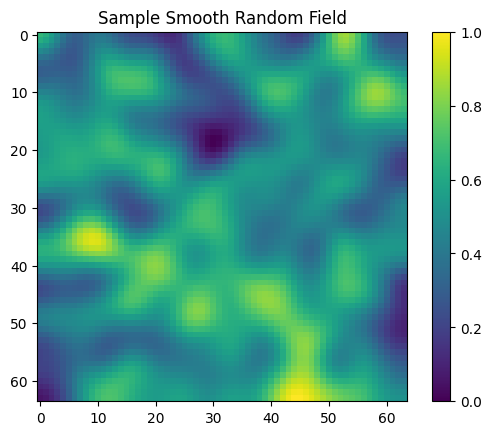

In [11]:
# --- Smooth Random Field Generator ---
grid_size = 64   # Size of the grid (i.e., 64x64 field)
sigma = 3.0      # Controls the smoothness of the field (higher = smoother)

def generate_random_field():
    # Start with random noise
    noise = np.random.rand(grid_size, grid_size)

    # Apply Gaussian blur, this "spreads out" the randomness
    blurred = gaussian_filter(noise, sigma=sigma)

    # Normalize it to [0, 1] range
    norm_field = (blurred - blurred.min()) / (blurred.max() - blurred.min())

    return norm_field

# --- Quick sanity check: visualize a sample field ---
field_example = generate_random_field()

# Plot it to see if it looks like what we expect
plt.imshow(field_example, cmap='viridis')
plt.title('Sample Smooth Random Field')
plt.colorbar()
plt.show()

---
## 3. Sparse Encoding via Sensor Masks

Reconstruction from $k\ll64^2$ sensors is inherently ill-posed. We represent sensor placements with a binary mask $m\in\{0,1\}^{64\times64}$ satisfying $\sum m_{ij}=k$. The observed data is the Hadamard product $f\odot m$. By stacking $f\odot m$ and $m$ as two input channels, the network explicitly knows which entries are measured versus missing, converting the inverse problem into a supervised learning task.

In [12]:
# --- Custom Dataset for Sensor Field Prediction ---
class SensorFieldDataset(Dataset):
    def __init__(self, num_samples, sensor_count):
        self.num_samples = num_samples
        self.sensor_count = sensor_count
        self.fields = [generate_random_field() for _ in range(num_samples)]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        field = self.fields[idx]

        # Flatten the field for easier indexing
        flattened = field.flatten().astype(np.float32)
        total_points = grid_size * grid_size

        # Randomly pick some sensor positions
        sensor_positions = np.random.choice(total_points, self.sensor_count, replace=False)

        # Build the binary mask indicating where sensors are placed
        sensor_mask = np.zeros(total_points, dtype=np.float32)
        sensor_mask[sensor_positions] = 1.0

        # Input has two channels: masked values + binary mask itself
        input_channels = np.stack([
            flattened * sensor_mask,
            sensor_mask
        ], axis=0).reshape(2, grid_size, grid_size)

        # Target is just the full field (single-channel)
        target = field[np.newaxis, ...].astype(np.float32)

        return torch.from_numpy(input_channels), torch.from_numpy(target)

---
## 4. CNN–LSTM–Attention Autoencoder Architecture

Capturing both local and global structure requires a hybrid model. The encoder applies three convolutional layers (kernel size $3\times3$, padding one) interleaved with $2\times2$ max pooling, reducing spatial resolution from $64$ to $8$ and increasing channel depth from $2$ to $128$. We reshape the resulting $8\times8\times128$ tensor into a sequence of 64 vectors in $\mathbb{R}^{128}$ and process it through an LSTM, which models spatial dependencies via gated recurrence. A multi‑head attention layer (4 heads) enables every token to attend to all others, capturing nonlocal relationships critical for reconstructing curvature. A residual connection preserves gradients from the attention output back to the LSTM features. The decoder then uses three transpose convolutions to restore the $64\times64$ resolution, with a Sigmoid activation enforcing outputs in $[0,1]$. We initialize all weights via Xavier to maintain variance stability, which is important when computing higher-order derivatives for adaptive sampling.


In [13]:
class ComplexAutoencoder(nn.Module):
    def __init__(self):
        super(ComplexAutoencoder, self).__init__()

        # Encoding part. compress the input
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # -> 8x8
        )

        # LSTM over the encoded spatial sequence
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)

        # Self-attention to help the network focus
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

        # Decoding back to full resolution
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),    # -> 16x16
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),     # -> 32x32
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2), nn.Sigmoid()    # -> 64x64
        )

        # Weight initialization (Xavier)
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        batch_size = x.size(0)

        # Encode the input
        encoded = self.encoder(x)  # [B, 128, 8, 8]

        # Reshape to sequence format for LSTM
        seq_input = encoded.view(batch_size, 128, -1).permute(0, 2, 1)  # [B, 64, 128]

        # Pass through LSTM
        lstm_output, _ = self.lstm(seq_input)  # [B, 64, 128]

        # Attention wants sequence-first format: already [B, 64, 128] with batch_first=True
        attn_output, _ = self.attn(lstm_output, lstm_output, lstm_output)

        # Residual connection
        combined = lstm_output + attn_output  # [B, 64, 128]

        # Reshape back to spatial grid
        combined_spatial = combined.permute(0, 2, 1).view(batch_size, 128, 8, 8)

        # Decode to full resolution
        out = self.decoder(combined_spatial)  # [B, 1, 64, 64]
        return out


---
## 5. Reconstruction Metrics: MSE, SSIM, and EMD

Quantitative evaluation employs complementary metrics: mean squared error ($\mathrm{MSE}=N^{-1}\sum(f_i-\hat f_i)^2$) penalizes pointwise deviations in the $\ell^2$-norm; structural similarity (SSIM) compares local statistics (mean, variance, covariance) across sliding windows to assess perceptual fidelity; and the Earth Mover’s Distance (1‑Wasserstein)

$$
W_1(p,q)=\inf_{\gamma\in\Gamma(p,q)}\int|x-y|\,d\gamma(x,y)
$$

measures distributional discrepancies by minimizing mass transport cost. For computational efficiency, we sample up to 1000 pixels at random when estimating EMD, balancing estimator variance and runtime.


In [14]:
# --- Evaluation Metrics ---
def calculate_mse(true, pred):
    # Standard mean squared error
    diff = true - pred
    squared = diff ** 2
    return np.mean(squared)

def calculate_ssim(true, pred):
    # SSIM is more about perceptual similarity
    return ssim(true, pred, data_range=1.0)  # Note: assumes normalized input in [0,1]

def calculate_emd(true, pred):
    # Earth Mover's Distance, compare distribution shapes
    t_flat = true.flatten()
    p_flat = pred.flatten()

    # Only sample 1000 points to make it faster
    sample_size = min(1000, t_flat.size)
    chosen = np.random.choice(t_flat.size, sample_size, replace=False)

    return wasserstein_distance(t_flat[chosen], p_flat[chosen])


---
## 6. Uniform Sampling Baseline for Domain Coverage

A uniform sampling mask partitions the grid into approximately $\lceil\sqrt{k}\rceil\times\lfloor\sqrt{k}\rfloor$ cells and places one sensor per cell, ensuring even domain coverage but ignoring field heterogeneity. This deterministic baseline quantifies the reconstruction quality achievable without adaptation.

In [15]:
# --- Create a roughly uniform sampling mask ---
def get_uniform_mask(k):
    # Figure out how to lay out roughly k points in a grid
    cols = int(np.floor(np.sqrt(k)))
    rows = int(np.ceil(k / cols)) # Might overshoot a bit — we'll clip later

    # Evenly spaced coordinates
    x_coords = np.linspace(0, grid_size - 1, cols, dtype=int)
    y_coords = np.linspace(0, grid_size - 1, rows, dtype=int)

    # Create grid of points, flatten it, then take first k
    candidate_points = np.stack(np.meshgrid(x_coords, y_coords), axis=-1)
    flat_points = candidate_points.reshape(-1, 2)[:k]

    # Init empty mask and mark the sampled points
    mask = np.zeros((grid_size, grid_size), dtype=float)
    for x, y in flat_points:
        mask[x, y] = 1.0  # Might need to flip x/y if indexing looks weird later

    return mask

---
## 7. Jacobian-Weighted Adaptive Sampling

After an initial reconstruction $\hat f$, we compute the pointwise residual $\varepsilon=|f-\hat f|$ and approximate the Hessian

$$
H=\begin{pmatrix}\hat f_{xx}&\hat f_{xy}\\\hat f_{yx}&\hat f_{yy}\end{pmatrix}
$$

via central finite differences. The Jacobian determinant of the affine map $I+\alpha H$ is

$$
J=\det(I+\alpha H) = (1+\alpha f_{xx})(1+\alpha f_{yy}) - (\alpha f_{xy})^2.
$$

We then assign importance

$$
I=(\beta\,\varepsilon/(J+\epsilon))^3,
$$

which prioritizes regions of both high curvature and high error. Iteratively selecting the top-$I$ grid points up to budget $k$ yields a mask optimized for information gain in subsequent reconstructions.

In [16]:
# --- Adaptive Sampling: focus sensors where model struggles ---
def get_adaptive_mask(field, base_mask, model, total_k, alpha=1.0, beta=10.0, eps=1e-6):
    # Build input for the model — same pattern as before: values + mask
    inp = np.stack([field * base_mask, base_mask], axis=0)[None, ...]  # shape: [1, 2, H, W]

    # Predict using current mask (no gradients needed here)
    with torch.no_grad():
        pred = model(torch.tensor(inp).float()).squeeze().numpy()

    # Simple absolute error map between true field and predicted one
    error_map = np.abs(field - pred)

    # Estimate second-order derivatives (for curvature estimation)
    fx, fy = np.gradient(pred)
    fxx, fxy = np.gradient(fx)
    _, fyy = np.gradient(fy)

    # Compute determinant of modified Hessian — used for spatial variation cue
    J = (1 + alpha * fxx) * (1 + alpha * fyy) - (alpha * fxy) ** 2

    # Importance score — mix of error and curvature
    importance = ((beta * error_map) / (J + eps)) ** 3

    # Figure out which positions are still unsampled
    flat_mask = base_mask.flatten()
    available_idxs = np.where(flat_mask == 0)[0]

    # Rank those by importance score (descending)
    importance_flat = importance.flatten()
    ranked = np.argsort(-importance_flat[available_idxs])

    # How many new points can we still add?
    current_k = int(base_mask.sum())
    num_new = max(0, total_k - current_k)

    # Pick the top candidates and update the mask
    selected = available_idxs[ranked[:num_new]]
    updated_flat = flat_mask.copy()
    updated_flat[selected] = 1.0

    return updated_flat.reshape(grid_size, grid_size)

---
## 8. Reconstruction Helper and Unified Evaluation

We encapsulate field reconstruction and metric computation into a single function that returns the predicted field, MSE, SSIM, EMD, and error map. This promotes code reuse and consistency across experimental runs.

In [17]:
def reconstruct_field(field,mask,model):
    inp = np.stack([field*mask,mask],0)[None]
    with torch.no_grad(): pred = model(torch.tensor(inp).float()).squeeze().numpy()
    return pred, calculate_mse(field,pred), calculate_ssim(field,pred), calculate_emd(field,pred), np.abs(field-pred)

---
## 9. Experimental Design and Main Loop

We compare three reconstruction strategies—global mean fill, uniform sampling, and Jacobian-weighted adaptive sampling—across budgets $k\in\{10,100,1000\}$. For each $k$, we train a new autoencoder (via a user-supplied `train_autoencoder` routine), reconstruct a fixed test field, and store all metrics in a pandas DataFrame. This framework quantifies the advantage conferred by curvature- and error-aware sampling relative to naive baselines.

In [ ]:
# --- Full Experiment Pipeline ---
import pandas as pd

def train_autoencoder(k):
    epochs = 40
    batch_size = 32

    # Step 1: dataset prep
    train_dataset = SensorFieldDataset(num_samples=400, sensor_count=k)
    test_dataset  = SensorFieldDataset(num_samples=100,  sensor_count=k)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # Step 2: model setup
    model = ComplexAutoencoder()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Step 3: training loop (fairly standard)
    model.train()
    for epoch in range(epochs):
        for inp, tgt in train_loader:
            optimizer.zero_grad()
            output = model(inp)
            loss = loss_fn(output, tgt)
            loss.backward()
            optimizer.step()
        # Could print loss here if debugging, skipping for now

    # Step 4: evaluate on test set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inp, tgt in test_loader:
            pred = model(inp)
            total_loss += loss_fn(pred, tgt).item() * inp.size(0)  # weight by batch size

    average_mse = total_loss / len(test_dataset)
    return average_mse, model


# Fixed field to evaluate different sampling strategies
fixed_field = generate_random_field()
budgets = [10, 100, 1000]  # Sensor counts to test

results = []
for k in budgets:
    print(f"Evaluating for budget k={k}")

    # Train model using current budget
    _, trained_model = train_autoencoder(k)

    # Baseline: use mean value everywhere
    dummy_pred = np.full_like(fixed_field, fixed_field.mean())
    baseline_metrics = (
        calculate_mse(fixed_field, dummy_pred),
        calculate_ssim(fixed_field, dummy_pred),
        calculate_emd(fixed_field, dummy_pred)
    )

    # Uniform sampling
    uniform_mask = get_uniform_mask(k)
    _, uni_mse, uni_ssim, uni_emd, _ = reconstruct_field(fixed_field, uniform_mask, trained_model)

    # Adaptive sampling
    initial_mask = get_uniform_mask(min(25, k))  # smaller base mask
    adapt_mask = get_adaptive_mask(fixed_field, initial_mask, trained_model, k)
    _, adapt_mse, adapt_ssim, adapt_emd, _ = reconstruct_field(fixed_field, adapt_mask, trained_model)

    # Store all results
    results.append({
        'k': k,
        'Simple MSE': baseline_metrics[0], 'Uniform MSE': uni_mse,      'Adaptive MSE': adapt_mse,
        'Simple SSIM': baseline_metrics[1], 'Uniform SSIM': uni_ssim,   'Adaptive SSIM': adapt_ssim,
        'Simple EMD': baseline_metrics[2], 'Uniform EMD': uni_emd,      'Adaptive EMD': adapt_emd
    })

# Final results
df = pd.DataFrame(results)
print(df.to_markdown(index=False))

Evaluating for budget k=10
